In [1]:
from google.colab import files
uploaded = files.upload()

Saving events_labels.csv to events_labels (1).csv


In [2]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['events_labels.csv']))

In [4]:
df.head()

,template,row,label
0,E1 E1 E1 E9 E8 Other E6 Other Other Other Othe...,1,Normal
1,E9 E1 E1 E1 E2 E2 E2 E7 E3 E8 E3 E6 E3 E11 E10...,2,Normal
2,E1 E1 E9 E1 E6 E17 E7 E17 E8 E17 E18 E18 E18,3,Normal
3,E1 E9 E1 E1 E2 E2 E2 E8 E3 E7 E3 E6 E3 E12 E10...,4,Normal
4,E1 E1 E1 E9 E6 E3 E8 E3 E7 E3 E2 E2 E2 E4 E4 E...,5,Normal


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575061 entries, 0 to 575060
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   template  575061 non-null  object
 1   row       575061 non-null  int64 
 2   label     575061 non-null  object
dtypes: int64(1), object(2)
memory usage: 13.2+ MB


In [6]:
df['label'].value_counts()

Normal     558223
Anomaly     16838
Name: label, dtype: int64

In [7]:
df['label'] = df['label'].map( {'Normal':0 , 'Anomaly':1} )
df['label'].value_counts()

0    558223
1     16838
Name: label, dtype: int64

In [8]:
# verify if labels are evenly distributed
df.iloc[:460000]['label'].value_counts()

0    449673
1     10327
Name: label, dtype: int64

In [9]:
df.iloc[460000:]['label'].value_counts()

0    108550
1      6511
Name: label, dtype: int64

# **Encoding**

In [10]:
X = df['template']
y = df['label']

In [11]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=False)
tokenizer.fit_on_texts(X)

In [12]:
print(tokenizer.texts_to_sequences(["E1"]))
print(tokenizer.texts_to_sequences(["E2"]))
print(tokenizer.texts_to_sequences(["Other"]))

[[1]]
[[2]]
[[16]]


In [13]:
for i, xi in enumerate(tokenizer.texts_to_sequences(X)):
    if i < 3:
        print(xi)
    else:
        exit

[1, 1, 1, 9, 8, 16, 6, 16, 16, 16, 16, 7, 16]
[9, 1, 1, 1, 2, 2, 2, 7, 3, 8, 3, 6, 3, 11, 10, 10, 11, 10, 10, 11, 10, 10, 4, 4, 4, 5, 5, 5]
[1, 1, 9, 1, 6, 18, 7, 18, 8, 18, 19, 19, 19]


In [14]:
X[0]

'E1 E1 E1 E9 E8 Other E6 Other Other Other Other E7 Other'

In [15]:
Xencoded_list = list()
# Xencoded = np.array([np.array(xi) for xi in tokenizer.texts_to_sequences(X)], dtype=int)

for i, xi in enumerate(tokenizer.texts_to_sequences(X)):
        temp = np.array(xi)
        temp.resize(300, refcheck = False)
        Xencoded_list.append(temp)

Xencoded = np.array(Xencoded_list, dtype = int)
Xencoded.shape

(575061, 300)

In [16]:
Xencoded[0]

array([ 1,  1,  1,  9,  8, 16,  6, 16, 16, 16, 16,  7, 16,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [17]:
tokenizer.word_index

{'e1': 1,
 'e10': 10,
 'e11': 11,
 'e12': 12,
 'e13': 13,
 'e14': 14,
 'e15': 15,
 'e16': 17,
 'e17': 18,
 'e18': 19,
 'e19': 20,
 'e2': 2,
 'e20': 22,
 'e21': 21,
 'e22': 23,
 'e23': 24,
 'e24': 25,
 'e25': 26,
 'e26': 27,
 'e27': 28,
 'e28': 29,
 'e29': 30,
 'e3': 3,
 'e30': 32,
 'e31': 31,
 'e32': 34,
 'e33': 33,
 'e34': 35,
 'e35': 36,
 'e36': 37,
 'e37': 39,
 'e38': 38,
 'e39': 40,
 'e4': 4,
 'e40': 41,
 'e41': 43,
 'e42': 45,
 'e43': 42,
 'e44': 44,
 'e5': 5,
 'e6': 6,
 'e7': 7,
 'e8': 8,
 'e9': 9,
 'other': 16}

# **Stratified Split**

In [18]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=0)

for train_index, test_index in sss.split(Xencoded, y):
     X_train, X_test = Xencoded[train_index], Xencoded[test_index]
     y_train, y_test = y[train_index], y[test_index]
    
print('X train :', X_train.shape)
print('X test :', X_test.shape)
print('y train :', y_train.shape)
print('y test :', y_test.shape)

X train : (460048, 300)
X test : (115013, 300)
y train : (460048,)
y test : (115013,)


In [19]:
y_train.value_counts()

0    446578
1     13470
Name: label, dtype: int64

In [20]:
y_test.value_counts()

0    111645
1      3368
Name: label, dtype: int64

In [21]:
X_train[0]

array([1, 1, 1, 9, 6, 3, 7, 3, 8, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
y_train.iloc[0]

0

# **Model**

In [23]:
model = keras.Sequential([
    keras.layers.Embedding(
        input_dim=len(tokenizer.word_index)+1,
        output_dim=64,
        mask_zero=True),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


In [24]:
# check if masking is available in all layers
print([layer.supports_masking for layer in model.layers])

[True, True, True, True]


In [25]:
model.compile(optimizer=keras.optimizers.Adam(1e-4), metrics=['accuracy'], loss = 'binary_crossentropy')


In [26]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/10
14377/14377 [==============================] - 212s 14ms/step - loss: 0.0519 - accuracy: 0.9898 - val_loss: 0.0025 - val_accuracy: 0.9995
Epoch 2/10
14377/14377 [==============================] - 206s 14ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0024 - val_accuracy: 0.9994
Epoch 3/10
14377/14377 [==============================] - 206s 14ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0018 - val_accuracy: 0.9995
Epoch 4/10
14377/14377 [==============================] - 202s 14ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 5/10
14377/14377 [==============================] - 204s 14ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0012 - val_accuracy: 0.9997
Epoch 6/10
14377/14377 [==============================] - 202s 14ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0018 - val_accuracy: 0.9994
Epoch 7/10
14377/14377 [==============================] - 201s 14ms/step - loss: 0.0013 - accuracy: 0.9996

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 2)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


3595/3595 - 16s - loss: 8.8422e-04 - accuracy: 0.9998
Test Loss: 0.0008842198876664042
Test Accuracy: 0.9998087286949158


In [28]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


(0.0, 0.01680543721304275)

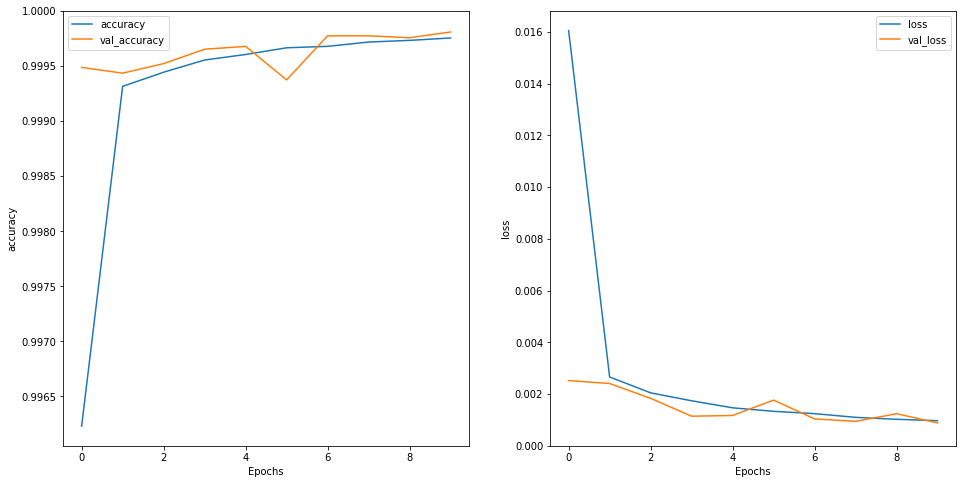

In [29]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


In [30]:
y_pred = model.predict_classes(X_test, batch_size=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [31]:
y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [32]:
y_pred.sum()

3368

In [33]:
y_test

22321     0
545986    0
246487    0
271485    0
298770    0
         ..
315919    0
371888    0
149380    0
432893    0
325865    0
Name: label, Length: 115013, dtype: int64

In [34]:
y_test.shape

(115013,)

In [41]:
y_pred.shape

(115013, 1)

In [42]:
y_pred_ = y_pred.reshape((115013,))
y_pred_.shape

(115013,)

In [43]:
confusion_matrix = pd.crosstab(y_test, y_pred_, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

Predicted,0,1
Actual,,
0,111634,11
1,11,3357


In [44]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred_))
print("Precision:", metrics.precision_score(y_test, y_pred_))
print("Recall:", metrics.recall_score(y_test, y_pred_))

Accuracy:  0.9998087172754384
Precision: 0.9967339667458432
Recall: 0.9967339667458432
